# Assignment IV

Atahan Özer - 6317973\
Karahan Sarıtaş - 6661689

## Problem 2
**(a)** Compute the graphlet kernel using sampling for the graphlets of size 3 (1000 samples). Perform a 10-fold
cross-validation for the binary classification problem using the kernel with an SVM. What is the accuracy for
the best $C \in \{0.0001, 0.001, 0.01, 0.1, 1, 10\}$? You can expect something larger than 0.8. Evaluating the accuracy
for the best $C$ value is sufficient, you do not have to evaluate the test accuracy separately. How many samples would you need such that the deviation from the real distribution is less than 0.05 with probability larger than 0.9?


In [1]:
from grakel.kernels import GraphletSampling
from grakel.kernels import WeisfeilerLehman
from grakel.kernels import VertexHistogram
from grakel.kernels import EdgeHistogram
from grakel.datasets import fetch_dataset
import numpy as np

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# https://ysig.github.io/GraKeL/0.1a8/documentation/introduction.html

MUTAG = fetch_dataset("MUTAG", verbose=False)
G = MUTAG.data
y = MUTAG.target
# G_i = Graph object, Node Labels, Edge Labels
len(G), len(y)  # y: {1, -1} binary classification

(188, 188)

In [57]:
# Graphlet sampling kernel
gk = GraphletSampling(k=3,
                      sampling={"n_samples": 1000},
                      random_state=15
                      )
K = gk.fit_transform(G)
K.shape

(188, 188)

In [59]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10]

In [45]:
def CV(n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=15)
    acc = []
    best, best_c = 0, 0
    for c in C:
        mean_acc = 0
        print("Run for C: {}".format(c))
        for train_index, val_index in kf.split(K):
            X_train, X_test = K[train_index][:, train_index], K[val_index][:, train_index]
            y_train, y_test = y[train_index], y[val_index]
            clf = SVC(kernel="precomputed", C=c)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print("Accuracy: {:.4f}".format(accuracy))
            acc.append(accuracy)
            mean_acc += accuracy
        mean_acc /= 10
        print("Average accuracy over splits: {:.4f} for C: {}".format(mean_acc, c))
        print("<", "-" * 60, ">", sep="")
        if not (mean_acc < best):
            best = mean_acc
            best_c = c
    print("Best accuracy: {:.4f} for C: {}".format(best, best_c))

CV()

Run for C: 0.0001
Accuracy: 0.8947
Accuracy: 0.8421
Accuracy: 0.6842
Accuracy: 0.9474
Accuracy: 0.7895
Accuracy: 0.8947
Accuracy: 0.7895
Accuracy: 0.8421
Accuracy: 0.7222
Accuracy: 0.8889
Average accuracy over splits: 0.8295 for C: 0.0001
<------------------------------------------------------------>
Run for C: 0.001
Accuracy: 0.8947
Accuracy: 0.8421
Accuracy: 0.6842
Accuracy: 0.9474
Accuracy: 0.7895
Accuracy: 0.8947
Accuracy: 0.7895
Accuracy: 0.8421
Accuracy: 0.7222
Accuracy: 0.8889
Average accuracy over splits: 0.8295 for C: 0.001
<------------------------------------------------------------>
Run for C: 0.01
Accuracy: 0.8947
Accuracy: 0.8421
Accuracy: 0.6842
Accuracy: 0.9474
Accuracy: 0.7895
Accuracy: 0.8947
Accuracy: 0.7895
Accuracy: 0.8421
Accuracy: 0.7222
Accuracy: 0.8889
Average accuracy over splits: 0.8295 for C: 0.01
<------------------------------------------------------------>
Run for C: 0.1
Accuracy: 0.8947
Accuracy: 0.8421
Accuracy: 0.6842
Accuracy: 0.9474
Accuracy: 0.7895


**A**: All $C$ values yield the same accuracy of  $82.95\%$. If we don't set the number of samples to $1000$, then the best accuracy is achieved when $C=0.1$ with an accuracy of $87.75\%$. 

**Theorem**: Let $D$ be a probability distribution on the finite set $A = \{1, ..., a\}$ (in our case set of all size $k$ graphlets). Let $X := \{X_j\}^{m}_{j=1}$, with $X_j \sim D$. For a given $\epsilon > 0$ and $\delta > 0$: 

$$
m = \left \lceil \frac{2 (\log 2 \cdot a + \log(\frac{1}{\delta}))}{\epsilon^{2}} \right \rceil
$$

samples are sufficient to satisfy the following 
inequality:
$$
P \left \{\lVert D - \^D^m \rVert_1 \geq \epsilon  \right\} \leq \delta
$$

* We have 188 many graphs in the dataset.
* In order to calculate the value of $a$, we have to calculate the number of all possible size 3 graphlets for the *largest* graph (so that the inequality holds for all graphs in the dataset).

In [46]:
max_nodes = 0
for g in G:
    n_nodes = len(g[1])
    max_nodes = max(max_nodes, n_nodes)
max_nodes

a = (max_nodes) * (max_nodes - 1) * (max_nodes - 2) / 6
a

3276.0

In [47]:
confidence = 0.9
epsilon = 0.05
delta = 1 - confidence

m = np.ceil(2 * (np.log(2) * a + np.log(1 / delta)) / (epsilon ** 2))
m


1818443.0

Calculated value appears to be extremely high. Observe that even the current number of samples we have are almost sufficient to get an accuracy of +0.80 with a higher confidence. One observartion is that there are remarkably less number of distinct graphlets than the total number of graphlets. According to the paper:

When dealing with unlabeled graphs, there are a total of $2^{ {n \choose k}}$ possible graphlets of size $k$. But, modulo isomorphism, there are only $N_k < 2^{ {n \choose k}}$ distinct graphlets. For example, consider the case $k = 4$: We have $a = N_k = 11$, while $2^{ {4 \choose 2}} = 64$. If we set $\epsilon = 0.05$ and $\delta = 0.05$, then our bound implies that we only need to sample 8,497 graphlets from a graph. If we decrease $\epsilon$ to $0.01$ and $\delta$ to $0.01$, then this number increases to $244,596$ [1].



[1] Shervashidze, N., Vishwanathan, S., Petri, T., Mehlhorn, K. &amp; Borgwardt, K.. (2009). Efficient graphlet kernels for large graph comparison. <i>Proceedings of the Twelth International Conference on Artificial Intelligence and Statistics</i>, in <i>Proceedings of Machine Learning Research</i> 5:488-495 Available from https://proceedings.mlr.press/v5/shervashidze09a.html.



There are at most 4 distinct graphlets of size 3:
* A graphlet where all nodes are connected to each other by a unique edge (complete graph).
* A graphlet where two nodes are not directly connected to each other.
* A graphlet where one node is independent from other nodes - whereas other two nodes are connected to each other.
* A graphlet where all nodes are independent from each other.

Let's take $a=4$ and calculate the number of samples needed to satisfy the inequality.

In [48]:
confidence = 0.9
epsilon = 0.05
delta = 1 - confidence
a = 4

m = np.ceil(2 * (np.log(2) * a + np.log(1 / delta)) / (epsilon ** 2))
m

4061.0

**(b)** Compute the Weisfeiler-Lehman subtree kernel for 4 iterations. Perform a 10-fold cross-validation for the binary classification problem using the kernel with an SVM. What is the accuracy for the best
$C \in \{0.0001, 0.001, 0.01, 0.1, 1, 10\}$? You can expect something larger than 0.85. Evaluating the accuracy for the best $C$ value is sufficient, you do not have to evaluate the test accuracy separately.

In [49]:
# Weisfeiler-Lehman subtree kernel
# https://ysig.github.io/GraKeL/0.1a8/auto_examples/weisfeiler_lehman_subtree.html#sphx-glr-auto-examples-weisfeiler-lehman-subtree-py
gk = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)
K = gk.fit_transform(G)
K.shape

(188, 188)

In [50]:
CV()

Run for C: 0.0001
Accuracy: 0.7895
Accuracy: 0.6316
Accuracy: 0.6842
Accuracy: 0.7895
Accuracy: 0.7368
Accuracy: 0.5789
Accuracy: 0.6316
Accuracy: 0.5789
Accuracy: 0.6667
Accuracy: 0.5556
Average accuracy over splits: 0.6643 for C: 0.0001
<------------------------------------------------------------>
Run for C: 0.001
Accuracy: 0.7895
Accuracy: 0.6316
Accuracy: 0.6842
Accuracy: 0.7895
Accuracy: 0.7368
Accuracy: 0.5789
Accuracy: 0.6316
Accuracy: 0.5789
Accuracy: 0.6667
Accuracy: 0.5556
Average accuracy over splits: 0.6643 for C: 0.001
<------------------------------------------------------------>
Run for C: 0.01
Accuracy: 0.7895
Accuracy: 0.6316
Accuracy: 0.6842
Accuracy: 0.7895
Accuracy: 0.7368
Accuracy: 0.5789
Accuracy: 0.6316
Accuracy: 0.5789
Accuracy: 0.6667
Accuracy: 0.5556
Average accuracy over splits: 0.6643 for C: 0.01
<------------------------------------------------------------>
Run for C: 0.1
Accuracy: 0.7895
Accuracy: 0.6316
Accuracy: 0.6842
Accuracy: 0.7895
Accuracy: 0.7368


Best accuracy is achieved when $C=10$ with an accuracy of $85.03\%$.

**(c)** Compute the Weisfeiler-Lehman edge kernel (WLedge.m) for 1 iteration. Perform a 10-fold cross-validation
for the binary classification problem using the kernel with an SVM. What is the accuracy for the best
$C \in \{0.0001, 0.001, 0.01, 0.1, 1, 10, 100\}$?


In order to compute the Weisfeiler-Lehman edge kernel, we will choose the graph base kernel as `EdgeHistogram`. But here is the caveat: Edge kernel used by the `EdgeHistogram` function is not the same as the Weisfeiler-Lehman edge kernel. To put it simply, `EdgeHistogram` kernel examines the edge labels in each graph, whereas the Weisfeiler-Lehman edge kernel examines the node labels $(a, b)$ for each edge. These labels have different meanings as explained by the documentation of MUTAG dataset:
"Explicit hydrogen atoms have been removed and vertices are labeled
by atom type and edges by bond type (single, double, triple or aromatic)."

So, the idea is to replace the edge labels with the format used in the Weisfeiler-Lehman edge kernel. We will replace the edge labels with an integer that corresponds to a unique tuple consisting of ordered labels (natural order) of the nodes that edge connects. Such bijective mapping can be done with prime integers. If we have an edge between nodes $a$ and $b$, then we will replace the edge label with an integer $x$ such that $f(x) = (a, b)$. This way, we will be able to use the `EdgeHistogram` kernel to compute the Weisfeiler-Lehman edge kernel.

In [60]:
for i in range(len(G)):
    graph_structure = G[i][0]
    node_labels = G[i][1]
    edge_labels = G[i][2]

    def bijective_mapping(tuple):
        # given a tuple, return a unique integer 
        # (a, b) -->  2^a * 3^b
        return 2**tuple[0] * 3**tuple[1]
    
    edge_labels_temp = edge_labels.copy()
    for edge in edge_labels_temp:
        label = edge_labels[edge]
        n1, n2 = edge[0], edge[1]

        n1_label = node_labels[n1]
        n2_label = node_labels[n2]
        # ordered labels
        if n1_label > n2_label:
            n1_label, n2_label = n2_label, n1_label
        edge_labels_temp[edge] = bijective_mapping((n1_label, n2_label))
    G[i] = (graph_structure, node_labels, edge_labels_temp)

In [61]:
gk = WeisfeilerLehman(n_iter=1, base_graph_kernel=EdgeHistogram, normalize=True)
K = gk.fit_transform(G)
K.shape

C = C + [100]

In [63]:
CV()

Run for C: 0.0001
Accuracy: 0.7895
Accuracy: 0.6316
Accuracy: 0.6842
Accuracy: 0.7895
Accuracy: 0.7368
Accuracy: 0.5789
Accuracy: 0.6316
Accuracy: 0.5789
Accuracy: 0.6667
Accuracy: 0.5556
Average accuracy over splits: 0.6643 for C: 0.0001
<------------------------------------------------------------>
Run for C: 0.001
Accuracy: 0.7895
Accuracy: 0.6316
Accuracy: 0.6842
Accuracy: 0.7895
Accuracy: 0.7368
Accuracy: 0.5789
Accuracy: 0.6316
Accuracy: 0.5789
Accuracy: 0.6667
Accuracy: 0.5556
Average accuracy over splits: 0.6643 for C: 0.001
<------------------------------------------------------------>
Run for C: 0.01
Accuracy: 0.7895
Accuracy: 0.6316
Accuracy: 0.6842
Accuracy: 0.7895
Accuracy: 0.7368
Accuracy: 0.5789
Accuracy: 0.6316
Accuracy: 0.5789
Accuracy: 0.6667
Accuracy: 0.5556
Average accuracy over splits: 0.6643 for C: 0.01
<------------------------------------------------------------>
Run for C: 0.1
Accuracy: 0.7895
Accuracy: 0.6316
Accuracy: 0.6842
Accuracy: 0.7895
Accuracy: 0.7368


Best accuracy is achieved when $C=100$ with an accuracy of $76.58\%$.

## Problem 3

Consider the Similarity Network Fusion (SNF) method with number of neighbors $k = 2$ (remember that the first
neighbor of a node is the node itself). Note: if you provide runnable code for $(a)$ and $(b)$, you can use $(c)$ to solve $(a)$ and $(b)$.


In [114]:
W1 = np.array([[1.00, 0.50, 0.30, 0.10, 0.10],
               [0.50, 1.00, 0.40, 0.10, 0.10],
               [0.30, 0.40, 1.00, 0.30, 0.30],
               [0.10, 0.10, 0.30, 1.00, 0.50],
               [0.10, 0.10, 0.30, 0.50, 1.00],
               ])
W2 = np.array([[1.00, 0.20, 0.50, 0.10, 0.10],
                [0.20, 1.00, 0.30, 0.10, 0.10],
                [0.50, 0.30, 1.00, 0.30, 0.30],
                [0.10, 0.10, 0.30, 1.00, 0.50],
                [0.10, 0.10, 0.30, 0.50, 1.00],
                ])

In [115]:
# SNF: Getting the similarity matrices (page: 22)
def normalized_weight_matrix(W):
    P = np.zeros(W.shape)
    for i in range(len(W)):
        denominator = np.sum(W[i])
        for j in range(len(W[i])):
            if i == j: P[i][j] = 0.5
            else: P[i][j] = W[i][j] / (2 * (denominator - W[i][i]))
    return P

# k nearest neighbors
def local_similarity_matrix(W, k = 2):
    S = np.zeros(W.shape)
    for i in range(len(W)):
        neighbors = np.argsort(-W[i])[:k]
        for j in neighbors: 
            denominator = np.sum(W[i][neighbors])
            S[i][j] = W[i][j] / denominator
    return S

**(a)**: Provide provide $P^{(1)}$, $P^{(2)}$, $S^{(1)}$, and $S^{(2)}$.

In [116]:
P1_0 = normalized_weight_matrix(W1)
P2_0 = normalized_weight_matrix(W2)
S1 = local_similarity_matrix(W1)
S2 = local_similarity_matrix(W2)
print("P^(1):\n", P1_0, "\nP^(2):\n", P2_0, "\nS1:\n", S1, "\nS2:\n", S2, sep="")

P^(1):
[[0.5        0.25       0.15       0.05       0.05      ]
 [0.22727273 0.5        0.18181818 0.04545455 0.04545455]
 [0.11538462 0.15384615 0.5        0.11538462 0.11538462]
 [0.05       0.05       0.15       0.5        0.25      ]
 [0.05       0.05       0.15       0.25       0.5       ]]
P^(2):
[[0.5        0.11111111 0.27777778 0.05555556 0.05555556]
 [0.14285714 0.5        0.21428571 0.07142857 0.07142857]
 [0.17857143 0.10714286 0.5        0.10714286 0.10714286]
 [0.05       0.05       0.15       0.5        0.25      ]
 [0.05       0.05       0.15       0.25       0.5       ]]
S1:
[[0.66666667 0.33333333 0.         0.         0.        ]
 [0.33333333 0.66666667 0.         0.         0.        ]
 [0.         0.28571429 0.71428571 0.         0.        ]
 [0.         0.         0.         0.66666667 0.33333333]
 [0.         0.         0.         0.33333333 0.66666667]]
S2:
[[0.66666667 0.         0.33333333 0.         0.        ]
 [0.         0.76923077 0.23076923 0.         0

$P^{(1)}_{t+1} = S^{(1)} \times P^{(2)}_t \times (S^{(1)})^T $ 

$P^{(2)}_{t+1} = S^{(2)} \times P^{(1)}_t \times (S^{(2)})^T $

**(b)**: Perform two steps of the similarity network fusion method (i.e., compute $P^{(1)}_1$, $P^{(2)}_1$, $P^{(1)}_2$, and $P^{(2)}_2$ as well as the corresponding $P^{(c)}_s$)

In [117]:
def update_normalized_weight_matrix(P, S):
    return S @ P @ S.T

P1_1 = update_normalized_weight_matrix(P2_0, S1)
P2_1 = update_normalized_weight_matrix(P1_0, S2)
P1_2 = update_normalized_weight_matrix(P2_1, S1)
P2_2 = update_normalized_weight_matrix(P1_1, S2)
Pc_0 = (P1_0 + P2_0) / 2
Pc_1 = (P1_1 + P2_1) / 2
Pc_2 = (P1_2 + P2_2) / 2


print("P^(1)_0:\n", P1_0, "\nP(2)_0:\n", P2_0,"\nP_c:\n", Pc_0, sep="")
print("<", "-" * 60, ">", sep="")
print("First iteration:")
print("P^(1)_1:\n", P1_1, "\nP^(2)_1:\n", P2_1, "\nP_c:\n", Pc_1, sep="")
print("Second iteration:")
print("P^(1)_2:\n", P1_2, "\nP^(2)_2:\n", P2_2, "\nP_c:\n", Pc_2, sep="")

P^(1)_0:
[[0.5        0.25       0.15       0.05       0.05      ]
 [0.22727273 0.5        0.18181818 0.04545455 0.04545455]
 [0.11538462 0.15384615 0.5        0.11538462 0.11538462]
 [0.05       0.05       0.15       0.5        0.25      ]
 [0.05       0.05       0.15       0.25       0.5       ]]
P(2)_0:
[[0.5        0.11111111 0.27777778 0.05555556 0.05555556]
 [0.14285714 0.5        0.21428571 0.07142857 0.07142857]
 [0.17857143 0.10714286 0.5        0.10714286 0.10714286]
 [0.05       0.05       0.15       0.5        0.25      ]
 [0.05       0.05       0.15       0.25       0.5       ]]
P_c:
[[0.5        0.18055556 0.21388889 0.05277778 0.05277778]
 [0.18506494 0.5        0.19805195 0.05844156 0.05844156]
 [0.14697802 0.13049451 0.5        0.11126374 0.11126374]
 [0.05       0.05       0.15       0.5        0.25      ]
 [0.05       0.05       0.15       0.25       0.5       ]]
<------------------------------------------------------------>
First iteration:
P^(1)_1:
[[0.33421517 0.2

**(c)**: Implement the SNF starting from the similarity matrices $W^{(i)}$ in Python with the convergence criterion $\epsilon$ as described in the supplement of the paper (Uni Tuebingen VPN necessary to access the full paper, supplement is freely available) and check whether the graph structure of the $P^{(c)}_t$ changes for $t > 2$ for the above described data.


From the paper: "SNF is proved to converge, and empirically it converges fast. We keep track of the relative change
in consecutive rounds $E_t = \frac{\left \Vert  W_{t+1}−W_t\right \Vert}{\left \Vert W_t\right \Vert} $. One simple stopping criteria is that we set a threshold $\epsilon = 10^{−6}$ and if the relative change is lower than the threshold, we stop the iteration" [1]


[1] Wang, B., Mezlini, A., Demir, F. et al. Similarity network fusion for aggregating data types on a genomic scale. Nat Methods 11, 333–337 (2014). https://doi.org/10.1038/nmeth.2810

In [118]:
def SNF(W1, W2, epsilon = 1e-6):
    P1 = normalized_weight_matrix(W1)
    P2 = normalized_weight_matrix(W2)
    S1 = local_similarity_matrix(W1)
    S2 = local_similarity_matrix(W2)
    P1_prev = P1
    P2_prev = P2
    Pc_prev = (P1 + P2) / 2
    itr = 0
    Pcs = [Pc_prev]
    print("Iteration {}:".format(itr))
    print("P^(1)_{}:\n".format(itr), P1_prev, "\nP^(2)_{}:\n".format(itr), P2_prev, "\nP_c:\n", Pc_prev, sep="")
    while True:
        itr += 1
        P1 = update_normalized_weight_matrix(P2_prev, S1)
        P2 = update_normalized_weight_matrix(P1_prev, S2)
        Pc = (P1 + P2) / 2
        print("Iteration {}:".format(itr))
        print("P^(1)_{}:\n".format(itr), P1, "\nP^(2)_{}:\n".format(itr), P2, "\nP_c:\n", Pc, sep="")
        Et = np.linalg.norm(Pc - Pc_prev) / np.linalg.norm(Pc_prev)
        print("Relative change in P_c: {:.10f}".format(Et))
        Pcs.append(Pc)
        if Et < epsilon:
            break
        P1_prev = P1
        P2_prev = P2
        Pc_prev = Pc
    return Pcs

In [119]:
Pcs = SNF(W1, W2)

Iteration 0:
P^(1)_0:
[[0.5        0.25       0.15       0.05       0.05      ]
 [0.22727273 0.5        0.18181818 0.04545455 0.04545455]
 [0.11538462 0.15384615 0.5        0.11538462 0.11538462]
 [0.05       0.05       0.15       0.5        0.25      ]
 [0.05       0.05       0.15       0.25       0.5       ]]
P^(2)_0:
[[0.5        0.11111111 0.27777778 0.05555556 0.05555556]
 [0.14285714 0.5        0.21428571 0.07142857 0.07142857]
 [0.17857143 0.10714286 0.5        0.10714286 0.10714286]
 [0.05       0.05       0.15       0.5        0.25      ]
 [0.05       0.05       0.15       0.25       0.5       ]]
P_c:
[[0.5        0.18055556 0.21388889 0.05277778 0.05277778]
 [0.18506494 0.5        0.19805195 0.05844156 0.05844156]
 [0.14697802 0.13049451 0.5        0.11126374 0.11126374]
 [0.05       0.05       0.15       0.5        0.25      ]
 [0.05       0.05       0.15       0.25       0.5       ]]
Iteration 1:
P^(1)_1:
[[0.33421517 0.28747795 0.25207861 0.06084656 0.06084656]
 [0.2980599

Iteration converges after 19 steps. In order to see the change in $Pc_t$ for $t>2$, we can plot the matrices.

P_c_0:


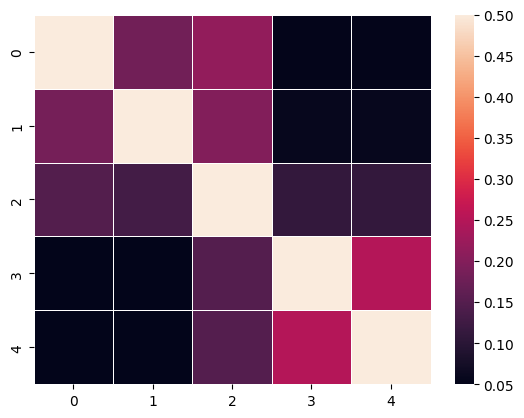

P_c_1:


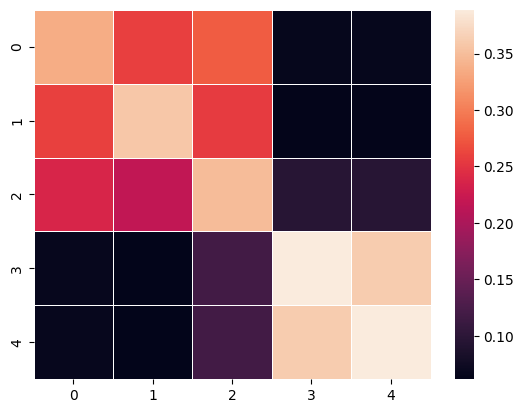

P_c_2:


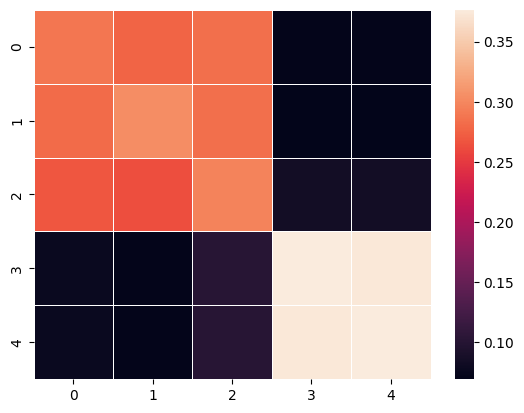

P_c_3:


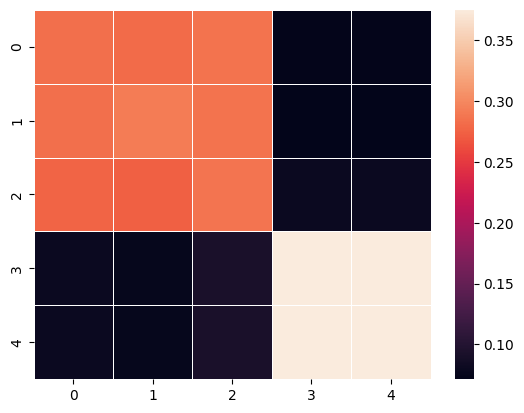

P_c_4:


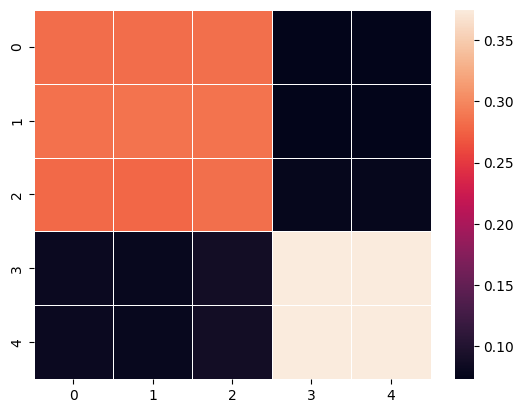

P_c_5:


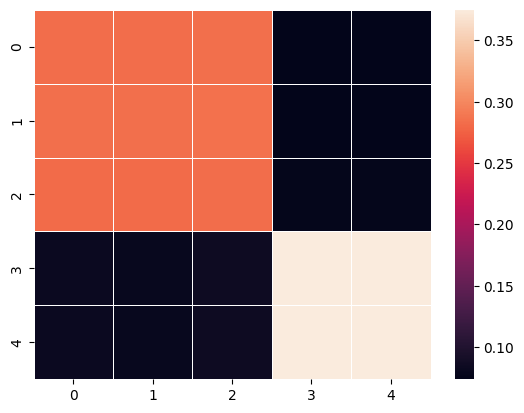

P_c_6:


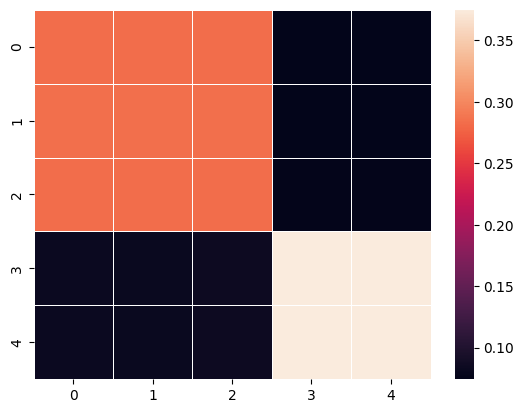

P_c_7:


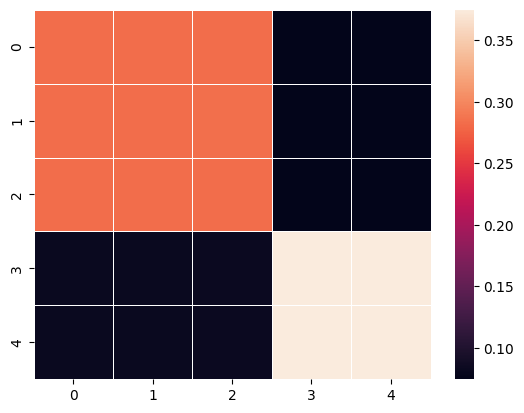

P_c_8:


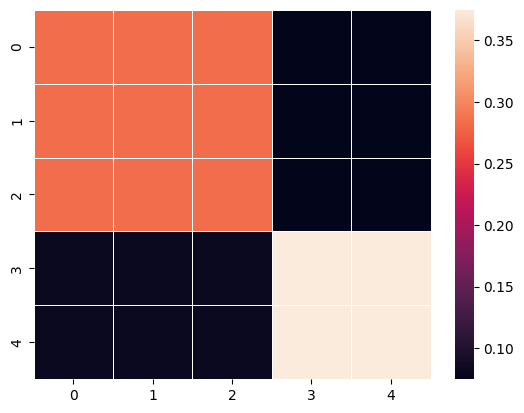

P_c_9:


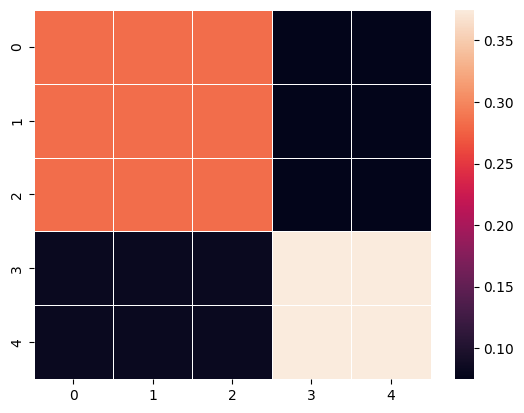

P_c_10:


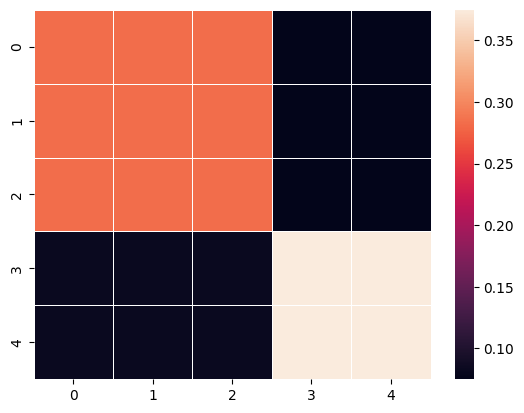

P_c_11:


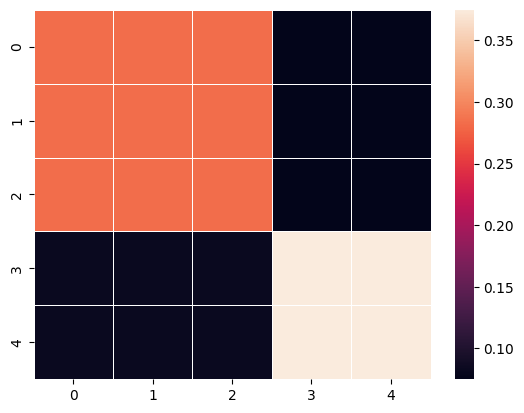

P_c_12:


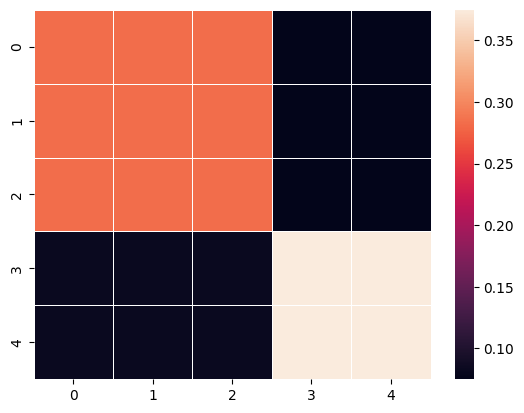

P_c_13:


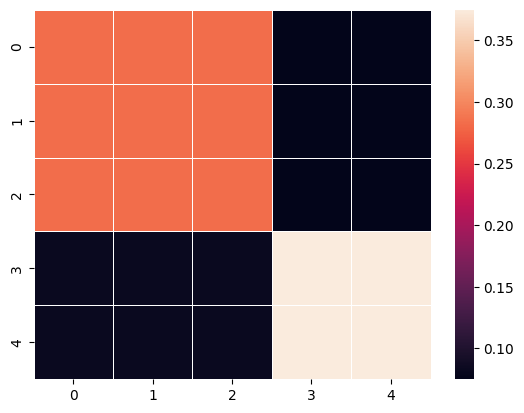

P_c_14:


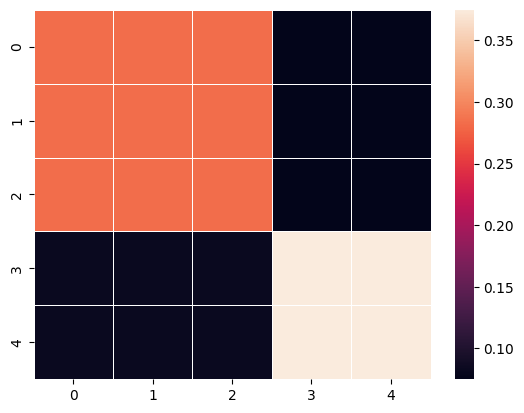

P_c_15:


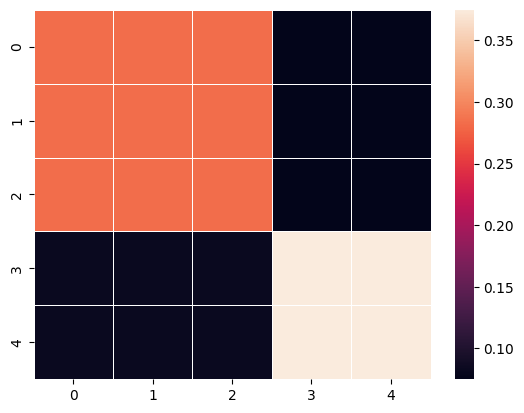

P_c_16:


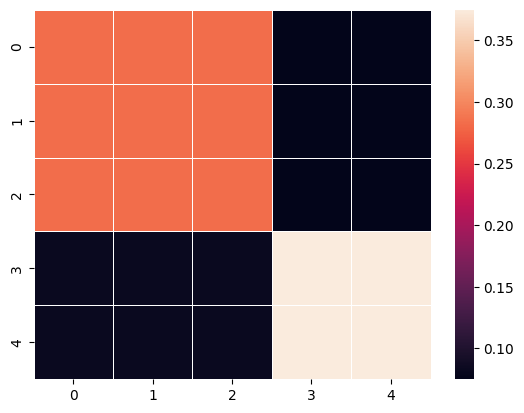

P_c_17:


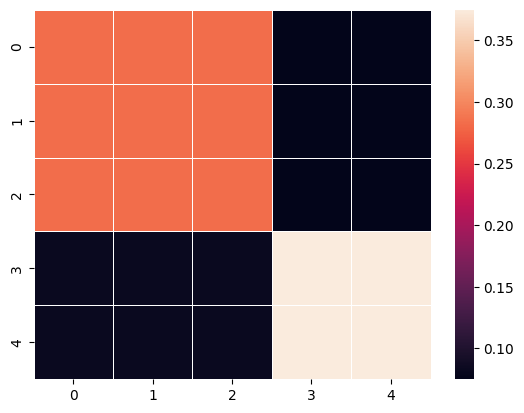

P_c_18:


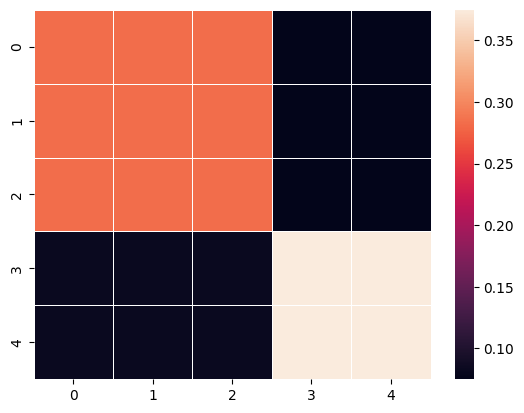

P_c_19:


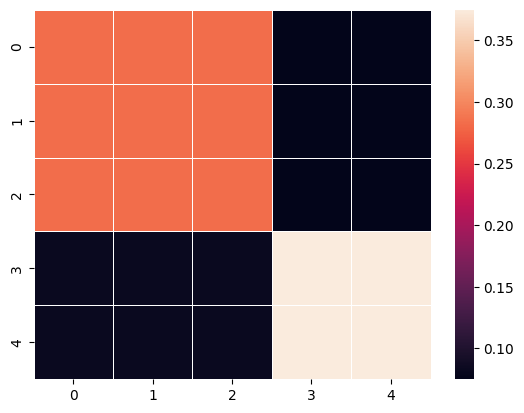

In [120]:
def plot_heatmap(P):
    ax = sns.heatmap(P, linewidth=0.5)
    plt.show()

for i in range(len(Pcs)):
    print("P_c_{}:".format(i))
    plot_heatmap(Pcs[i])

As can be seen from the heatmaps above, the graph structure of $P^{(c)}_t$ does not experience a remarkable change after $t>4$ and the change is almost negligible after $t>19$.